# Char-RNN for Shakespeare dataset

### Libraries

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import string
import random
import matplotlib.pyplot as plt

### Functions

In [17]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Storing the sets of punctuation, digits, ascii_letters and whitespace in variable result 
all_characters = string.printable

# Turn a string into a tensor
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

### Model

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self,input,hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.lstm(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden
    
    def init_hidden(self,batch_size):
        h_0 = Variable(torch.zeros(self.num_layers,batch_size,self.hidden_size)).to(device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers,batch_size,self.hidden_size)).to(device) #internal state
        return h_0, c_0


### Text generator

In [19]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, output_file='output.txt'):
    hidden = decoder.init_hidden(1)
    prime_input = char_tensor(prime_str)

    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p].view(1).to(device), hidden)
        
    inp = prime_input[-1].to(device)
    
    with open(output_file, 'w') as f:
        for p in range(predict_len):
            output, hidden = decoder(inp.view(1), hidden)
            
            # Sample from the network as a multinomial distribution
            output_dist = output.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0]

            # Add predicted character to string and use as next input
            predicted_char = all_characters[top_i]
            predicted += predicted_char
            inp = char_tensor(predicted_char).to(device)

            # Write predicted character to file
            f.write(predicted_char)

    return predicted

### Training-data functions

In [20]:
def random_training_set(chunk_len, batch_size, text):
    data = torch.LongTensor(batch_size, chunk_len).to(device)
    label = torch.LongTensor(batch_size, chunk_len).to(device)
    for bi in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        data[bi] = char_tensor(chunk[:-1])
        label[bi] = char_tensor(chunk[1:])
    data = Variable(data)
    label = Variable(label)
    return data, label

## Task 1: Training

Epoch 10, Loss: 660.9611206054688
Epoch 20, Loss: 605.2757568359375
Epoch 30, Loss: 531.9139404296875
Epoch 40, Loss: 490.5523681640625
Epoch 50, Loss: 463.91912841796875
Epoch 60, Loss: 445.77691650390625
Epoch 70, Loss: 431.8836669921875
Epoch 80, Loss: 422.91357421875
Epoch 90, Loss: 412.7845764160156
Epoch 100, Loss: 397.3552551269531
Epoch 110, Loss: 393.7324523925781
Epoch 120, Loss: 383.06207275390625
Epoch 130, Loss: 371.4809265136719
Epoch 140, Loss: 368.21759033203125
Epoch 150, Loss: 367.8774719238281
Epoch 160, Loss: 360.59185791015625
Epoch 170, Loss: 356.6219787597656
Epoch 180, Loss: 350.43914794921875
Epoch 190, Loss: 346.1008605957031
Epoch 200, Loss: 345.862548828125
Epoch 210, Loss: 342.5257263183594
Epoch 220, Loss: 338.9504699707031
Epoch 230, Loss: 336.1804504394531
Epoch 240, Loss: 338.83721923828125
Epoch 250, Loss: 334.7604675292969
Epoch 260, Loss: 325.8818664550781
Epoch 270, Loss: 332.203857421875
Epoch 280, Loss: 324.86053466796875
Epoch 290, Loss: 331.4998

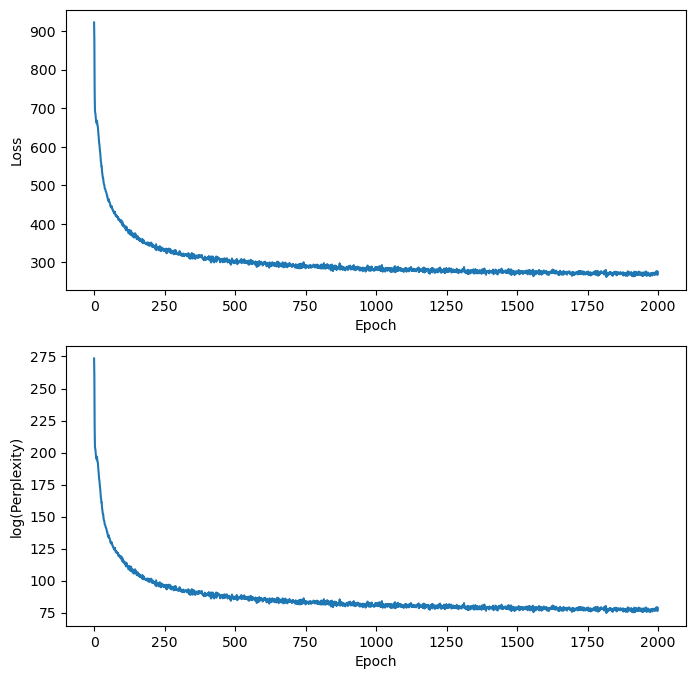

In [21]:
num_epochs = 2000
learning_rate = 0.01
batch_size = 100
chunk_len = 200

input_size = 300
hidden_size = 100
output_size = len(all_characters)
num_layers = 2

with open("data/tinyshakespeare/input.txt", "r") as f:
    text = f.read()

model = LSTM(input_size=input_size, hidden_size=hidden_size, output_size = output_size, 
             num_layers=num_layers).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

losses = []
perplexities = []

# Training
for epoch in range(num_epochs):

    data, label = random_training_set(chunk_len, batch_size, text)
    hidden = model.init_hidden(batch_size)
    hidden = (hidden[0].to(device), hidden[1].to(device))
    data = data.to(device)
    label = label.to(device)

    loss = 0
    total_perplexity = 0

    # Feed forward and backpropagation
    for c in range(chunk_len):
        output, hidden = model(data[:, c], hidden)
        loss += criterion(output.view(batch_size, -1), label[:, c])
        perplexity = 2 ** loss.item()
        total_perplexity += perplexity

    avg_perplexity = total_perplexity / (batch_size * chunk_len)
    perplexities.append(avg_perplexity)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

    # Print the loss every 10 epochs
    if epoch % 10 == 9:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Plot loss and perplexity as a function of epochs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

ax1.plot(losses)
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epoch")

ax2.plot(np.log10(perplexities))
ax2.set_ylabel("log(Perplexity)")
ax2.set_xlabel("Epoch")

plt.show()

## Task 2: Text samples (Random Seed)

In [22]:
# Generate some text, seed 'blablabla'
print("-------------------------------------------------")
print("Priming seed: 'blablabla'")
print("-------------------------------------------------")
generated_text = generate(model, prime_str='blablabla', predict_len=100, temperature=0.8, output_file='output.txt')
print(generated_text)
print("\n")

# Generate some text, seed '2 b3n'
print("-------------------------------------------------")
print("Priming seed: '2 b3n'")
print("-------------------------------------------------")
generated_text1 = generate(model, prime_str='2 b3n', predict_len=100, temperature=0.8, output_file='output.txt')
print(generated_text1)
print("\n")

# Generate some text, seed 'bg09Z'
print("-------------------------------------------------")
print("Priming seed: 'bg09Z'")
print("-------------------------------------------------")
generated_text2 = generate(model, prime_str='bg09Z', predict_len=100, temperature=0.8, output_file='output.txt')
print(generated_text2)
print("\n")

-------------------------------------------------
Priming seed: 'blablabla'
-------------------------------------------------
blablabland to like of their with thy out you:
But I part can for me for what is he is a possess;
Stant it st


-------------------------------------------------
Priming seed: '2 b3n'
-------------------------------------------------
2 b3new; there, he shall ben:
Thou art faith's bodies; and by more, to say; he?
Nor must direction is swo


-------------------------------------------------
Priming seed: 'bg09Z'
-------------------------------------------------
bg09Zon, those to look, sir,
My master is the roving I the woman as he
Deishes slave we may I read may sh




## Task 3: Text samples (Worded Seed)

In [24]:
# Generate some text, seed 'The'
print("-------------------------------------------------")
print("Priming seed: 'The'")
print("-------------------------------------------------")
generated_text3 = generate(model, prime_str='The', predict_len=100, temperature=0.8, output_file='output.txt')
print(generated_text3)
print("\n")

# Generate some text, seed 'What is'
print("-------------------------------------------------")
print("Priming seed: 'What is'")
print("-------------------------------------------------")
generated_text4 = generate(model, prime_str='What is', predict_len=100, temperature=0.8, output_file='output.txt')
print(generated_text4)
print("\n")

# Generate some text, seed 'Shall I give'
print("-------------------------------------------------")
print("Priming seed: 'Shall I give'")
print("-------------------------------------------------")
generated_text5 = generate(model, prime_str='Shall I give', predict_len=100, temperature=0.8, output_file='output.txt')
print(generated_text5)
print("\n")

# Generate some text, seed 'X087hNYB BHN BYFVuhsdbs'
print("-------------------------------------------------")
print("Priming seed: 'X087hNYB BHN BYFVuhsdbs'")
print("-------------------------------------------------")
generated_text6 = generate(model, prime_str='X087hNYB BHN BYFVuhsdbs', predict_len=100, temperature=0.8, output_file='output.txt')
print(generated_text6)

-------------------------------------------------
Priming seed: 'The'
-------------------------------------------------
The causior that powers where their prove most remembrance;
We would the good all: the each a mind; he 


-------------------------------------------------
Priming seed: 'What is'
-------------------------------------------------
What is't to me all the former their life their eyes are
To her inteors like no moot and other asle,
befel 


-------------------------------------------------
Priming seed: 'Shall I give'
-------------------------------------------------
Shall I give thee land of his honour death.

First Servant:
Thou would he shall we bless'd that quide, kiss and 


-------------------------------------------------
Priming seed: 'X087hNYB BHN BYFVuhsdbs'
-------------------------------------------------
X087hNYB BHN BYFVuhsdbs allows,
And there again he proclaim of the tongues:
Hed one no less is 'tis intercesses,
Thoughters


## Task 5: Word Based RNN (Shakespeare dataset)

### Tokenizes .txt file

In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn

from collections import Counter
import warnings

import string

import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

torch.autograd.set_detect_anomaly(True)

In [26]:
batch_size = 16
seq_size = 32
embedding_size = 64
lstm_size = 64
gradients_norm = 5
# set device parameter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
# read document
with open("data/tinyshakespeare/input.txt", "r") as f:
    doc = f.read()

In [28]:
# Removes all newlines
lines = doc.split('\n')

# Creates a vector of words
words = ' '.join(lines).split()
# Creates list of special charaters
punctuations = set(string.punctuation)
# Removes all special charaters
words = [''.join([char for char in list(word) if char not in punctuations]) for word in words]
print(words)

# Counts how many times each word as apperd
wordfreq = Counter(words)
# And sortes them from least to most common
sorted_wordfreq = sorted(wordfreq, key=wordfreq.get, reverse=True)
print(wordfreq)

# Assignes number with unique word
int_to_vocab = {k:w for k,w in enumerate(sorted_wordfreq)}
vocab_to_int = {w:k for k,w in int_to_vocab.items()}
print(vocab_to_int)

['First', 'Citizen', 'Before', 'we', 'proceed', 'any', 'further', 'hear', 'me', 'speak', 'All', 'Speak', 'speak', 'First', 'Citizen', 'You', 'are', 'all', 'resolved', 'rather', 'to', 'die', 'than', 'to', 'famish', 'All', 'Resolved', 'resolved', 'First', 'Citizen', 'First', 'you', 'know', 'Caius', 'Marcius', 'is', 'chief', 'enemy', 'to', 'the', 'people', 'All', 'We', 'knowt', 'we', 'knowt', 'First', 'Citizen', 'Let', 'us', 'kill', 'him', 'and', 'well', 'have', 'corn', 'at', 'our', 'own', 'price', 'Ist', 'a', 'verdict', 'All', 'No', 'more', 'talking', 'ont', 'let', 'it', 'be', 'done', 'away', 'away', 'Second', 'Citizen', 'One', 'word', 'good', 'citizens', 'First', 'Citizen', 'We', 'are', 'accounted', 'poor', 'citizens', 'the', 'patricians', 'good', 'What', 'authority', 'surfeits', 'on', 'would', 'relieve', 'us', 'if', 'they', 'would', 'yield', 'us', 'but', 'the', 'superfluity', 'while', 'it', 'were', 'wholesome', 'we', 'might', 'guess', 'they', 'relieved', 'us', 'humanely', 'but', 'they'

In [29]:

def get_batches(words, vocab_to_int, batch_size, seq_size):
    # generate a Xs and Ys of shape (batchsize * num_batches) * seq_size
    word_ints = [vocab_to_int[word] for word in words]
    num_batches = int(len(word_ints) / (batch_size * seq_size))
    Xs = word_ints[:num_batches*batch_size*seq_size]
    Ys = np.zeros_like(Xs)
    Ys[:-1] = Xs[1:]
    Ys[-1] = Xs[0]
    Xs = np.reshape(Xs, (num_batches*batch_size, seq_size))
    Ys= np.reshape(Ys, (num_batches*batch_size, seq_size))
    
    # iterate over rows of Xs and Ys to generate batches
    for i in range(0, num_batches*batch_size, batch_size):
        yield Xs[i:i+batch_size, :], Ys[i:i+batch_size, :]

In [30]:
class RNNModule(nn.Module):
    # initialize RNN module
    def __init__(self, n_vocab, seq_size=32, embedding_size=64, lstm_size=64):
        super(RNNModule, self).__init__()
        self.seq_size = seq_size
        self.lstm_size = lstm_size
        self.embedding = nn.Embedding(n_vocab, embedding_size)
        self.lstm = nn.LSTM(embedding_size, lstm_size, batch_first=True)
        self.dense = nn.Linear(lstm_size, n_vocab)
        
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.dense(output)

        return logits, state
    
    def zero_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.lstm_size),torch.zeros(1, batch_size, self.lstm_size))
model=RNNModule(len(sorted_wordfreq))
model

RNNModule(
  (embedding): Embedding(14746, 64)
  (lstm): LSTM(64, 64, batch_first=True)
  (dense): Linear(in_features=64, out_features=14746, bias=True)
)

In [31]:
def generate_text(device, net, words, n_vocab, vocab_to_int, int_to_vocab, top_k=5):
    net.eval()

    state_h, state_c = net.zero_state(1)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    for w in words:
        ix = torch.tensor([[vocab_to_int[w]]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))
    
    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0])

    words.append(int_to_vocab[choice])
    
    for _ in range(100):
        ix = torch.tensor([[choice]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))

        _, top_ix = torch.topk(output[0], k=top_k)
        choices = top_ix.tolist()
        choice = np.random.choice(choices[0])
        words.append(int_to_vocab[choice])

    print(' '.join(words))

In [36]:
def train_rnn(words, vocab_to_int, int_to_vocab, n_vocab):
    
    # RNN instance
    net = RNNModule(n_vocab, seq_size, embedding_size, lstm_size)
    net = net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    Batch = 0
    Epochs = 400
    losses = []
    perplexities = []
    
    for e in range(Epochs):
        batches = get_batches(words, vocab_to_int, batch_size, seq_size)
        state_h, state_c = net.zero_state(batch_size)
        loss = 0
        total_perplexity = 0
        # Transfer data to GPU
        state_h = state_h.to(device)
        state_c = state_c.to(device)
        for x, y in batches:
            Batch += 1

            # Tell it we are in training mode
            net.train()

            # Reset all gradients
            optimizer.zero_grad()

            # Transfer data to GPU
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)
            
            logits, (state_h, state_c) = net(x, (state_h, state_c))
            loss = criterion(logits.transpose(1, 2), y.long())

            state_h = state_h.detach()
            state_c = state_c.detach()            
            
            perplexity = 2 ** loss.item()
            total_perplexity += perplexity
            avg_perplexity = total_perplexity / (batch_size * seq_size)
            
            # Perform back-propagation
            loss.backward(retain_graph=True)

            _ = torch.nn.utils.clip_grad_norm_(net.parameters(), gradients_norm)
            
            # Update the network's parameters
            optimizer.step()

        print('Epoch: {}/{}'.format(e+1, Epochs),'Loss: {}'.format(loss.item()))
        
        perplexities.append(avg_perplexity)
        losses.append(loss.item())  
        Batch=0
        
        
    # Plot loss and perplexity as a function of epochs
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

    ax1.plot(losses)
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Epoch")

    ax2.plot(np.log10(perplexities))
    ax2.set_ylabel("log(Perplexity)")
    ax2.set_xlabel("Epoch")

    plt.show()
    return net

Epoch: 1/400 Loss: 7.700403690338135
Epoch: 2/400 Loss: 7.4657721519470215
Epoch: 3/400 Loss: 7.234426498413086
Epoch: 4/400 Loss: 7.0349016189575195
Epoch: 5/400 Loss: 6.874203681945801
Epoch: 6/400 Loss: 6.745726585388184
Epoch: 7/400 Loss: 6.634862422943115
Epoch: 8/400 Loss: 6.531245708465576
Epoch: 9/400 Loss: 6.428058624267578
Epoch: 10/400 Loss: 6.326779842376709
Epoch: 11/400 Loss: 6.2266011238098145
Epoch: 12/400 Loss: 6.120046138763428
Epoch: 13/400 Loss: 6.024023056030273
Epoch: 14/400 Loss: 5.94015645980835
Epoch: 15/400 Loss: 5.9011993408203125
Epoch: 16/400 Loss: 5.833276748657227
Epoch: 17/400 Loss: 5.756863594055176
Epoch: 18/400 Loss: 5.675581455230713
Epoch: 19/400 Loss: 5.597171306610107
Epoch: 20/400 Loss: 5.519265651702881
Epoch: 21/400 Loss: 5.444961071014404
Epoch: 22/400 Loss: 5.365402698516846
Epoch: 23/400 Loss: 5.30369234085083
Epoch: 24/400 Loss: 5.2333598136901855
Epoch: 25/400 Loss: 5.167656898498535
Epoch: 26/400 Loss: 5.106842517852783
Epoch: 27/400 Loss

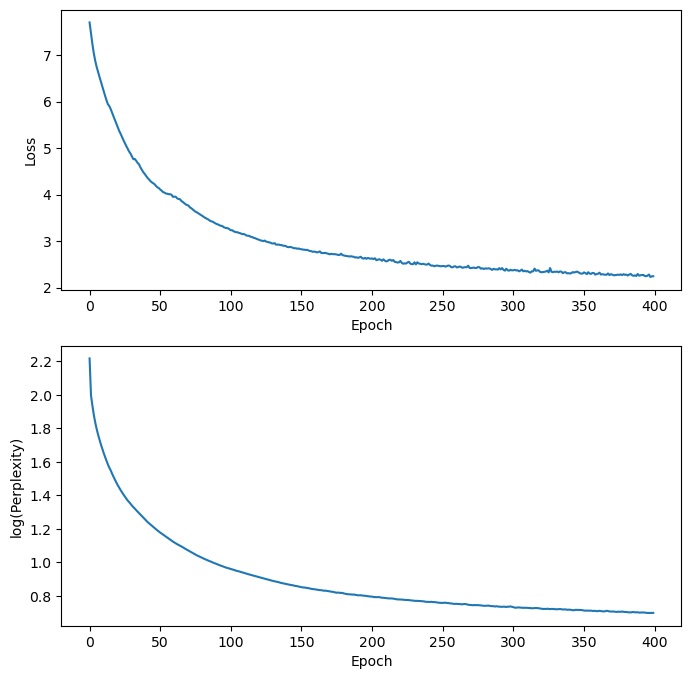

First you Thereon using bodily owe gentlewomen ROSS Twice dearly towns notwithstanding join regreet distance glued fearful LUCENTIO Upon a goodly Duke o Gods sake who drawn the dawning respect Hes virtue whipped out in vain with an hour we have approved by whereof Heaven consult more time Did you famish am worse you shall understand her putting a lookingglass desert than an evil Angelo Hath Lies froward As with our ears Were city to his lustful eye die not Please it it in her heart And now I leave me here Ill give again The foe where would not take my fan


In [37]:
rnn_net = train_rnn(words, vocab_to_int, int_to_vocab, len(sorted_wordfreq))

generate_text(device, rnn_net, ['First', 'you'], len(sorted_wordfreq), vocab_to_int, int_to_vocab)

In [38]:
generate_text(device, rnn_net, ['The'], len(sorted_wordfreq), vocab_to_int, int_to_vocab)

The Ho questionthat audience tellst bestrid imprisond Capitol nod lurk Keepdown permit discords stale naughty toys grass Condition dishes shaft Brandon parentage Infer Greek it Hath often heard thee in thy countrys chiefest Into me As any more are made LEONTES No more amazement For the office sir I know it not yourself nor very priests will to her For I have heard my fathers house Thou shouldst have found thy back For I will resist my house For this day if you had a fault so long to be brief Here come from them Come for these good news I must


In [43]:
generate_text(device, rnn_net, ['which', 'is'], len(sorted_wordfreq), vocab_to_int, int_to_vocab)

which is shortend hoars learnd surfeits walls Killing interpretation summons event mules grove repeald commons lurchd earnest graces success corn at dreadful story beast An prisoners brothers ghost my face here hast thou to continue his head in his tail KATHARINA Nor proved the life which is Rome for the drabs Provost Fie me to express grandam it will I be at home I will have no time as he is young man I have showd a stranger in a lusty story nobly Have I been the worst For they have done my youngest will give up her daughter Servant This it lies
